# Portfolio project: Predicting stock prices using pandas and scikit-learn

In this project, we will be predicting stock prices using pandas and scikit-learn. To do so, we will download stock prices using `yfinance`, create a machine learning model, and develop a backtesting engine.  

### Introduction 

The stock market is unpredictable and making money requires a lot of thought on the movement of the market. As we want to make money, we only want to buy stock on days when the price will go up. We'll create a machine learning algorithm to predict if the stock price will increase tomorrow. If the algorithm says that the price will increase, we'll buy stock. If the algorithm says that the price will go down, we wil not purchase any stock.

We want to maximize true positives(days when the algorithm predicts that the price will go up, and it actually goes up) Therefore, we'll be using precision score as our error metric for our algorithm, which is true positives / (false positives + true positives). This will ensure that we minimize how much money we lose with false positives (days when we buy the stock, but the price actually goes down). This means that we will have to accept a lot of false negatives - days when we predict that the price will go down, but it actually goes up. This is okay since we'd rather minimize our potential losses than maximize potential gains.

### Method

We'll be looking the SP500, which has the stock symbol `^GSPC`.  

Here are the steps that we'll follow to make predictions on the price of `^GSPC` stock:

* Download SP500 stock prices from Yahoo finance
* Explore the data
* Setup the dataset to predict future prices using historical prices
* Test a machine learning model
* Setup a backtesting engine
* Improve the accuracy of the model

At the end, we'll document some potential future directions we can go in to improve the predictions.

## Gathering Data
First, we'll download the data from Yahoo Finance.  To do this we import the `yfinance` python package.  

In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
sp500 = yf.Ticker("^GSPC")

In [3]:
sp500 = sp500.history(period="max")

In [4]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

### Exploring the data

Next, we can take a look at `sp500` to see the structure of the data. 

As we can see below, we have one row of data for each day the SP500 stock was traded.  Here are the columns:

* Open - the price the stock opened at.
* High - the highest price during the day
* Low - the lowest price during the day
* Close - the closing price on the trading day
* Volume - how many shares were traded

The row index of the DataFrame is the date the stock was traded.  The stock market doesn't operate every day, so some dates are missing due to holidays and weekends.

In [5]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-18 00:00:00-04:00,4357.350098,4364.200195,4303.839844,4314.600098,3686030000,0.0,0.0
2023-10-19 00:00:00-04:00,4321.359863,4339.540039,4269.689941,4278.000000,3969730000,0.0,0.0
2023-10-20 00:00:00-04:00,4273.850098,4276.560059,4223.029785,4224.160156,4004030000,0.0,0.0


In [6]:
sp500.index

Index(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
       '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
       '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
       '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
       '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
       ...
       '2023-10-11 00:00:00-04:00', '2023-10-12 00:00:00-04:00',
       '2023-10-13 00:00:00-04:00', '2023-10-16 00:00:00-04:00',
       '2023-10-17 00:00:00-04:00', '2023-10-18 00:00:00-04:00',
       '2023-10-19 00:00:00-04:00', '2023-10-20 00:00:00-04:00',
       '2023-10-23 00:00:00-04:00', '2023-10-24 00:00:00-04:00'],
      dtype='object', name='Date', length=24069)

<Axes: xlabel='Date'>

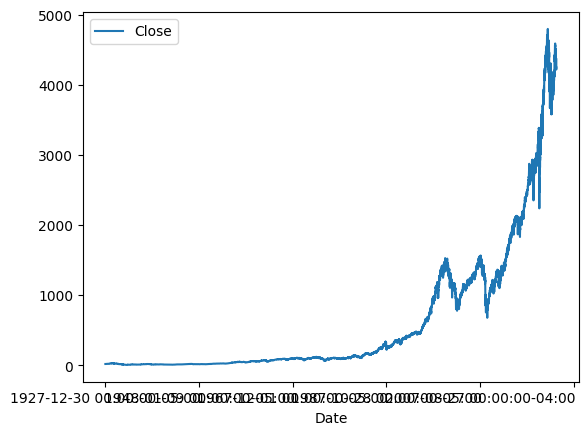

In [7]:
# Visualize SP500 stock prices
sp500.plot.line(y="Close", use_index=True)

## Preparing the data

First, we'll identify a target that we're trying to predict.  Our target will be predicting if the price will go up or down tomorrow.  If the price went up, the target will be `1`, and if it went down, the target will be `0`.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target. 

Then, we'll combine both so we have our training data.

We will also be deleting rows that are unnecessary for our model.

In [8]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [9]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [10]:
sp500

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2023-10-18 00:00:00-04:00,4357.350098,4364.200195,4303.839844,4314.600098,3686030000,4278.000000
2023-10-19 00:00:00-04:00,4321.359863,4339.540039,4269.689941,4278.000000,3969730000,4224.160156
2023-10-20 00:00:00-04:00,4273.850098,4276.560059,4223.029785,4224.160156,4004030000,4217.040039


In [11]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [12]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2023-10-18 00:00:00-04:00,4357.350098,4364.200195,4303.839844,4314.600098,3686030000,4278.000000,0
2023-10-19 00:00:00-04:00,4321.359863,4339.540039,4269.689941,4278.000000,3969730000,4224.160156,0
2023-10-20 00:00:00-04:00,4273.850098,4276.560059,4223.029785,4224.160156,4004030000,4217.040039,0


In [13]:
sp500 = sp500.loc["1990-01-01":].copy()

In [14]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-10-18 00:00:00-04:00,4357.350098,4364.200195,4303.839844,4314.600098,3686030000,4278.000000,0
2023-10-19 00:00:00-04:00,4321.359863,4339.540039,4269.689941,4278.000000,3969730000,4224.160156,0
2023-10-20 00:00:00-04:00,4273.850098,4276.560059,4223.029785,4224.160156,4004030000,4217.040039,0


## Creating a machine learning model

Next, we'll create a machine learning model to see how accurately we can predict the trend of the stock.

As this is time series data, we will not be able to use cross-validation to create predictions for the whole dataset. Instead, we'll split the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

We will implement a random forest classifier to generate our predictions, because it can pick up nonlinear relationships in the data, and helps to prevent overfitting.

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state = 1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=200, random_state=1)

Next, we'll need to check how accurate the model was.  To do this we will import the `precision_score` function from scikit-learn.

In [16]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [17]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1])

In [18]:
preds = pd.Series(preds, index = test.index)

In [19]:
preds

Date
2023-06-02 00:00:00-04:00    1
2023-06-05 00:00:00-04:00    1
2023-06-06 00:00:00-04:00    1
2023-06-07 00:00:00-04:00    1
2023-06-08 00:00:00-04:00    1
                            ..
2023-10-18 00:00:00-04:00    1
2023-10-19 00:00:00-04:00    1
2023-10-20 00:00:00-04:00    1
2023-10-23 00:00:00-04:00    0
2023-10-24 00:00:00-04:00    1
Length: 100, dtype: int32

In [20]:
precision_score(test["Target"], preds)

0.4861111111111111

Our model currently is only right 49% of the time. We will take a lot at the data and see if we can use different predictors to calculate with a higher accuracy

In [21]:
combined = pd.concat([test["Target"], preds], axis = 1)

<Axes: xlabel='Date'>

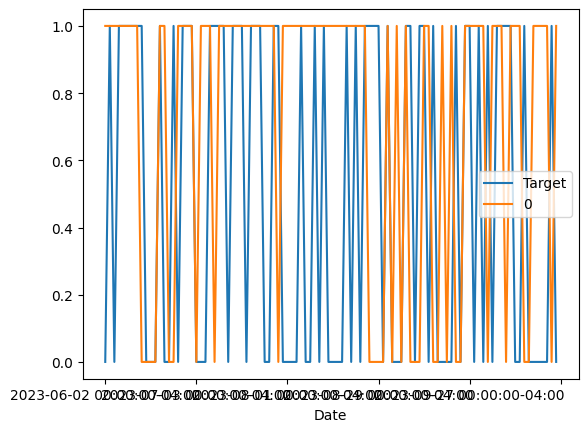

In [22]:
combined.plot()

## Backtesting
To improve our predictions, we will make predictions across the entire dataset, not just the last 100 rows from the data. 

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm will not be applicable to the real world.

The backtesting method will loop over the dataset, and train a model every 250 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:

* Split the training and test data
* Train a model
* Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives.


In [23]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [24]:
def backtest(data, model, predictors, start=2000,step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [25]:
predictions = backtest(sp500, model, predictors)

In [26]:
predictions["Predictions"].value_counts()

Predictions
0    3860
1    2659
Name: count, dtype: int64

In [27]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5268898081985709

In [28]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.53275
0    0.46725
Name: count, dtype: float64

## Improving accuracy

We will try using different predictors to improve the accuracy of predicting the target.

We will try creating some rolling averages, so the model can evaluate the current price against recent prices.  We'll also look at the ratios between different indicators.

In [29]:
horizons = [2,5,60,250,1000]

new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [30]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-18 00:00:00-04:00,4357.350098,4364.200195,4303.839844,4314.600098,3686030000,4278.000000,0,0.993255,0.0,0.992372,1.0,0.976395,27.0,1.036452,125.0,1.105324,529.0
2023-10-19 00:00:00-04:00,4321.359863,4339.540039,4269.689941,4278.000000,3969730000,4224.160156,0,0.995741,0.0,0.987206,1.0,0.969168,27.0,1.027055,125.0,1.095600,529.0
2023-10-20 00:00:00-04:00,4273.850098,4276.560059,4223.029785,4224.160156,4004030000,4217.040039,0,0.993668,0.0,0.979466,1.0,0.958104,27.0,1.013671,124.0,1.081485,528.0


In [31]:
sp500 = sp500.dropna()

In [32]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-17 00:00:00-04:00,4345.229980,4393.569824,4337.540039,4373.200195,3794850000,4314.600098,0,0.999951,1.0,1.002974,2.0,0.988713,28.0,1.051154,125.0,1.120703,530.0
2023-10-18 00:00:00-04:00,4357.350098,4364.200195,4303.839844,4314.600098,3686030000,4278.000000,0,0.993255,0.0,0.992372,1.0,0.976395,27.0,1.036452,125.0,1.105324,529.0
2023-10-19 00:00:00-04:00,4321.359863,4339.540039,4269.689941,4278.000000,3969730000,4224.160156,0,0.995741,0.0,0.987206,1.0,0.969168,27.0,1.027055,125.0,1.095600,529.0


In [33]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=50, random_state=1)

In [34]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.65] = 1
    preds[preds < 0.65] = 0
    preds = pd.Series(preds, index=test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [35]:
predictions = backtest(sp500, model, new_predictors)

In [36]:
predictions["Predictions"].value_counts()

Predictions
0.0    5361
1.0     157
Name: count, dtype: int64

In [37]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5859872611464968

## Next steps

There are a lot of next steps we could take to improve our predictions to achieve a higher accuracy score:

### Improve the technique

* Calculate the money that could've have been made if we followed the algorithm 

### Improve the algorithm

* Try discarding older data (only keeping data in a certain window)
* Try a different machine learning algorithm
* Tweak random forest parameters, or the prediction threshold

### Add in more predictors

* Account for activity post-close and pre-open
    * Early trading
    * Trading on other exchanges that open before the NYSE (to see what the global sentiment is)
* Economic indicators
    * Interest rates
    * Other important economic news
* Company milestones
    * Earnings calls
    * Analyst ratings
    * Major announcements
* Prices of related stocks
    * Other companies in the same sector
    * Key partners, customers, etc.